In [1]:
import os, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Input
from keras.optimizers import Adam
from keras.models import Model


dataset = pd.read_csv('../data/Dataset_refined/complete.csv', sep=',')
test_set = pd.read_csv('../data/Dataset_refined/test_f5.csv', sep=',')
test_set = test_set.drop(['velocity'], axis=1)
dataset = dataset.drop(['velocity'], axis=1)
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:,-1].values
#speed = dataset.iloc[:,0].values

test_set_X = test_set.iloc[:,0:-1].values
test_set_y = test_set.iloc[:,-1].values


#os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.


In [2]:
right_turns = y[np.where(y > 0.1)]
left_turns = y[np.where(y < -0.1)]
straight = y[np.where(abs(y) < 0.1)]
print("Number of Straight: ", straight.shape[0])
print("Number of right turns: ", right_turns.shape[0])
print("Number of left turns: ", left_turns.shape[0])
print("max: ", np.amax(y))
print("median: ", np.median(y))
print("min: ", np.amin(y))
print("Number of left turns: ", left_turns.shape[0])

Number of Straight:  5630
Number of right turns:  2601
Number of left turns:  2666
max:  0.4189
median:  -0.037106018513441086
min:  -0.4189
Number of left turns:  2666


In [3]:
dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,1072,1073,1074,1075,1076,1077,1078,1079,1080,steering_angle
count,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,...,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000,10897.000000
mean,1.390143,1.377555,1.365892,1.356876,1.347964,1.337836,1.328644,1.319315,1.310158,1.303314,...,2.293451,2.312977,2.352677,2.364796,2.413107,2.467643,2.418718,2.466672,2.481843,-0.004793
std,0.941996,0.917864,0.899946,0.890882,0.883283,0.874095,0.862577,0.853286,0.847149,0.845058,...,6.922566,6.975383,7.105035,7.105590,7.283052,7.480324,7.208055,7.381589,7.404913,0.241248
min,0.295000,0.297000,0.295000,0.287000,0.286000,0.285000,0.285000,0.282000,0.280000,0.282000,...,0.416000,0.422000,0.425000,0.425000,0.427000,0.435000,0.442000,0.444000,0.442000,-0.418900
25%,0.930000,0.926000,0.922000,0.918000,0.913000,0.908000,0.904000,0.899000,0.895000,0.891000,...,0.923000,0.928000,0.935000,0.942000,0.947000,0.953000,0.961000,0.970000,0.978000,-0.098054
50%,1.116000,1.112000,1.106000,1.102000,1.097000,1.091000,1.086000,1.080000,1.073000,1.066000,...,1.237000,1.243000,1.249000,1.253000,1.261000,1.267000,1.274000,1.279000,1.286000,-0.037106
75%,1.539000,1.531000,1.522000,1.514000,1.506000,1.498000,1.490000,1.480000,1.469000,1.463000,...,1.747000,1.754000,1.767000,1.779000,1.784000,1.794000,1.805000,1.815000,1.824000,0.083250
max,8.040000,8.080000,8.132000,8.177000,8.177000,8.085000,8.122000,8.141000,8.191000,8.186000,...,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,0.418900


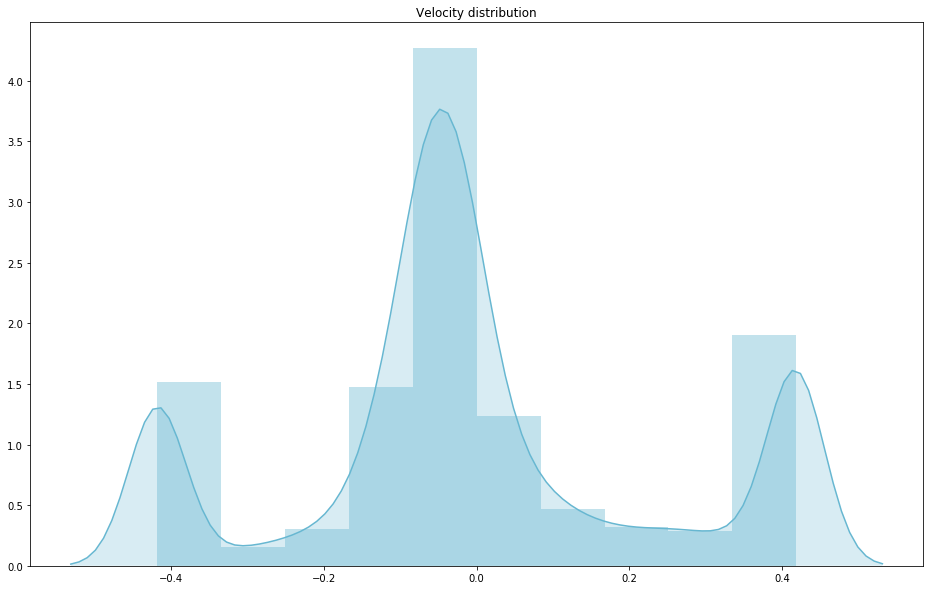

In [3]:
fig = plt.figure(figsize=(16,10))
# green - #3cb44b
# blue - #67B7D1
sns.distplot(y, bins=10, hist=True, kde_kws={"shade": True}, color='#67B7D1')
plt.title('Velocity distribution', loc='center')
plt.show()

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

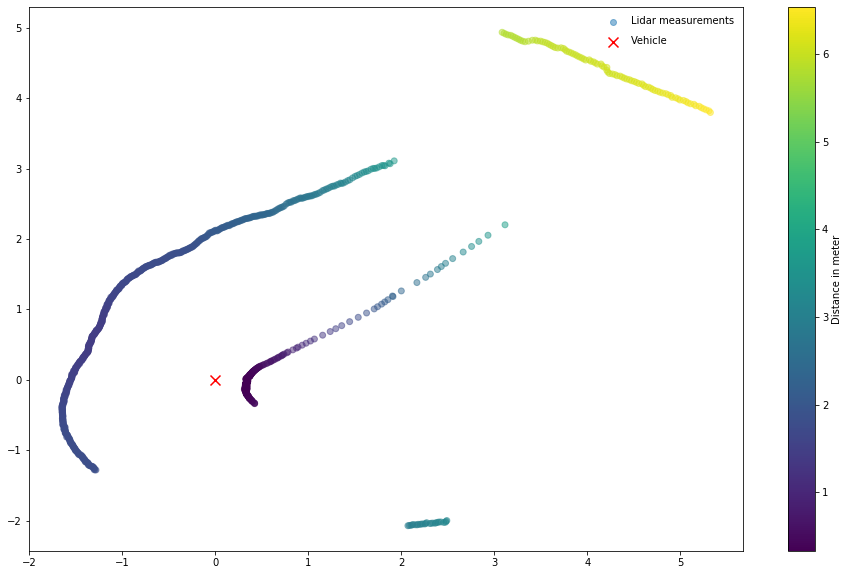

Output:  -0.4189


In [8]:
#Plot data
angle_inc = math.radians(0.25)
angle_start = -math.radians(45)

SEQ_IDX= 100
data_plot= x_train[SEQ_IDX]

x = []
y = []

for i in range(len(data_plot)):
    angle = angle_start + i * angle_inc
    x.append(data_plot[i]*math.cos(angle))
    y.append(data_plot[i]*math.sin(angle))

norm = mpl.colors.Normalize(vmin=np.amin(data_plot), vmax=np.amax(data_plot))

fig = plt.figure(figsize=(16,10))
plt.scatter(x,y, c=(data_plot), cmap='viridis', marker='o', alpha=0.5, label='Lidar measurements')
plt.scatter(x=0, y=0,s=100, c='r', marker="x", label='Vehicle')
plt.axis(aspect='equal')

plt.colorbar(mpl.cm.ScalarMappable(norm=norm), label='Distance in meter')
plt.legend(labelspacing=1,frameon=False)
plt.show()
print("Output: ", y_train[SEQ_IDX])

In [9]:
#Normalization
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
scaler.fit(X)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [34]:
#MLP Grid search model
mlp = MLPRegressor(max_iter=200)
parameter_space = {
    'hidden_layer_sizes': [(80,100,80)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train, y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (80, 100, 80), 'learning_rate': 'constant', 'solver': 'adam'}
0.764 (+/-0.075) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (80, 100, 80), 'learning_rate': 'constant', 'solver': 'adam'}
0.702 (+/-0.198) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 10, 5), 'learning_rate': 'constant', 'solver': 'adam'}


In [10]:
#Train MLP from Grid Search
mlp_best = MLPRegressor(
    hidden_layer_sizes=(80,100,80),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='constant',
    max_iter=200,
    early_stopping=True
)
mlp_best.fit(x_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(80, 100, 80), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

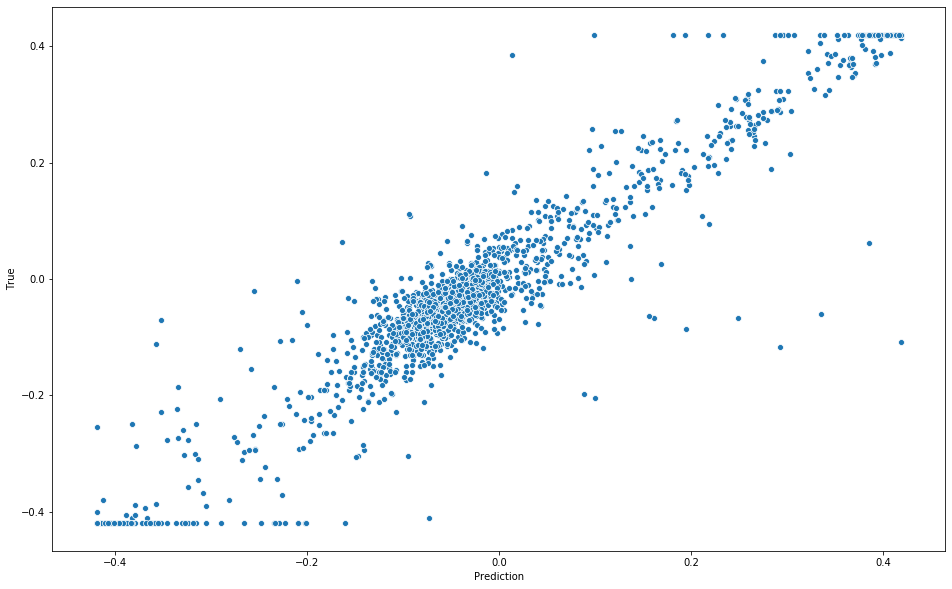

R2:  0.9550060758559618
MAE:  0.029343686669545805
MSE:  0.0025698207128862834


In [11]:
y_pred = mlp_best.predict(x_test)
y_pred = np.clip(y_pred, -0.4189, 0.4189)

results = pd.DataFrame()
results['Prediction'] = y_pred
results['True'] = y_test

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax1 = sns.scatterplot(x='Prediction', y='True', data=results, palette=cmap)
plt.show()
print("R2: ", r2_score(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))

0.17756648615231133


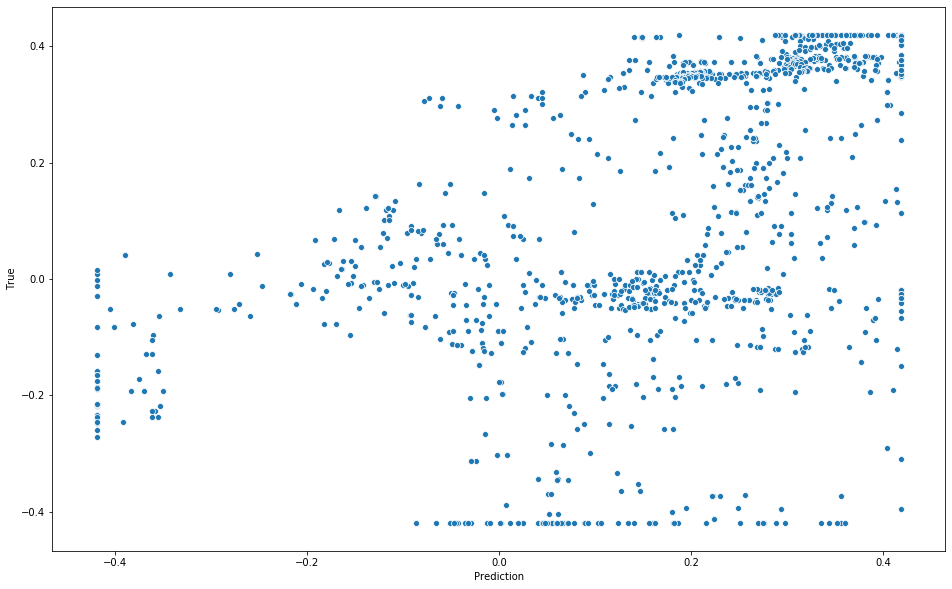

R2:  0.10793997560173685
MAE:  0.18090418897050065
MSE:  0.05668651029685919


In [12]:
#Normalize
scaler = MinMaxScaler()
scaler.fit(test_set_X)
test_set_X = scaler.transform(test_set_X)

#Predict
y_pred = mlp_best.predict(test_set_X)
y_pred = np.clip(y_pred, -0.4189, 0.4189)

results_test = pd.DataFrame()
results_test['Prediction'] = y_pred
results_test['True'] = test_set_y

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax1 = sns.scatterplot(x='Prediction', y='True', data=results_test, palette=cmap)
plt.show()
print("R2: ", r2_score(test_set_y, y_pred))
print("MAE: ", mean_absolute_error(test_set_y, y_pred))
print("MSE: ", mean_squared_error(test_set_y, y_pred))

In [4]:
#Keras sequential model
inputs = Input(shape=(1081,))

dense1 = Dense(80)(inputs)
dense1 = Activation("relu")(dense1)

dense2 = Dense(100)(dense1)
dense2 = Activation("relu")(dense2)

dense3 = Dense(80)(dense2)
dense3 = Activation("relu")(dense3)


final = Dense(1)(dense3)

model = Model(inputs=inputs, outputs=final)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1081)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                86560     
_________________________________________________________________
activation_1 (Activation)    (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               8100      
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                8080      
_________________________________________________________________
activation_3 (Activation)    (None, 80)                0   

In [5]:
from keras import metrics
model.compile(loss='mean_squared_error',
              optimizer= Adam(), metrics=[metrics.mae])

In [7]:
#y_train_cat = keras.utils.to_categorical(y_train_res, 2)
#y_test_cat = keras.utils.to_categorical(y_test, 2)
from sklearn.preprocessing import MinMaxScaler

X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:,-1].values

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

x_t, x_v, y_t, y_v = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
BATCH_SIZE = 24 
EPOCHS = 30

history = model.fit(x_t,y_t,
                    verbose=1,
                    epochs= EPOCHS,
                    validation_data=(x_v,y_v))

Train on 8717 samples, validate on 2180 samples
Epoch 1/30
8717/8717 [==============================] - 5s 573us/step - loss: 0.0148 - mean_absolute_error: 0.0867 - val_loss: 0.0107 - val_mean_absolute_error: 0.0718
Epoch 2/30
8717/8717 [==============================] - 3s 351us/step - loss: 0.0095 - mean_absolute_error: 0.0668 - val_loss: 0.0078 - val_mean_absolute_error: 0.0605
Epoch 3/30
8717/8717 [==============================] - 3s 344us/step - loss: 0.0080 - mean_absolute_error: 0.0594 - val_loss: 0.0069 - val_mean_absolute_error: 0.0556
Epoch 4/30
8717/8717 [==============================] - 3s 332us/step - loss: 0.0068 - mean_absolute_error: 0.0540 - val_loss: 0.0063 - val_mean_absolute_error: 0.0565
Epoch 5/30
8717/8717 [==============================] - 3s 342us/step - loss: 0.0069 - mean_absolute_error: 0.0559 - val_loss: 0.0062 - val_mean_absolute_error: 0.0550
Epoch 6/30
8717/8717 [==============================] - 3s 333us/step - loss: 0.0062 - mean_absolute_error: 0.05

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test MAE:', score[1])


Test loss: 0.004143861900809982
Test MAE: 0.04006678983569145


In [9]:
model.save('model_Onetrack.h')